In [1]:
import pandas as pd
import numpy as np
from pybaseball import statcast
from pybaseball import pitching_stats
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from unidecode import unidecode
import datetime as dt
import requests
import statsapi


In [ ]:
"""
data20_22 = statcast(start_dt = "2020-04-01", end_dt = "2022-12-01") 
data20_22.to_csv('Statcast_2020_to_2022.csv')
data23 = statcast(start_dt = "2023-04-01", end_dt = "2023-12-01")
data23.to_csv('Statcast_2023.csv')
"""

In [2]:
#Read in data
#data20_22 = pd.read_csv("Statcast_2020_to_2022.csv")
#data23 = pd.read_csv("Statcast_2023.csv")

temp_data = pd.read_csv("Statcast_2020_to_2023.csv")
data20_22 = temp_data.loc[temp_data['game_year'] < 2023]
data23 = temp_data.loc[temp_data['game_year'] == 2023]

/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_33826/3553435919.py:5: DtypeWarning: Columns (25,97) have mixed types. Specify dtype option on import or set low_memory=False.
  temp_data = pd.read_csv("Statcast_2020_to_2023.csv")


In [4]:
#data20_22 = pd.concat([data20_22,data23])
#data23 = statcast("2024-03-28","2024-06-30")

This is a large query, it may take a moment to complete


  0%|          | 0/95 [00:00<?, ?it/s]/Users/maxwassarman/miniconda3/envs/baseball/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  1%|          | 1/95 [00:05<07:58,  5.10s/it]/Users/maxwassarman/miniconda3/envs/baseball/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  2%|▏         | 2/95 [00:06<04:08,  2.67s/it]/Users/maxwassarman/miniconda3/envs/baseball/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessin

In [4]:
data20_22['player_name'] = data20_22['player_name'].apply(unidecode)
data23['player_name'] = data23['player_name'].apply(unidecode)

/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_33826/3467714004.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data20_22['player_name'] = data20_22['player_name'].apply(unidecode)
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_33826/3467714004.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data23['player_name'] = data23['player_name'].apply(unidecode)


In [5]:
#Select columns
data20_22 = data20_22[['player_name','pitch_type','release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','vz0','ax','ay','az','game_year','stand','p_throws','delta_run_exp','balls','strikes','new_run_value']]
data23 = data23[['player_name','pitch_type','release_speed','release_pos_x','release_pos_z','release_spin_rate','release_extension','spin_axis','pfx_x', 'pfx_z','vx0','vy0','vz0','ax','ay','az','game_year','stand','p_throws','delta_run_exp','balls','strikes','new_run_value']]

In [6]:
data20_22['p_throws'] = data20_22['p_throws'].map({'L': 0, 'R': 1})
data23['p_throws'] = data23['p_throws'].map({'L': 0, 'R': 1})

data20_22['stand'] = data20_22['stand'].map({'L': 0, 'R': 1})
data23['stand'] = data23['stand'].map({'L': 0, 'R': 1})

/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_33826/3100037148.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data20_22['p_throws'] = data20_22['p_throws'].map({'L': 0, 'R': 1})
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_33826/3100037148.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data20_22['stand'] = data20_22['stand'].map({'L': 0, 'R': 1})


In [7]:
#Drop na values
data20_22 = data20_22.dropna()
data23 = data23.dropna()

In [8]:
#Flip to get view from pitcher
data20_22['pfx_x'] = data20_22['pfx_x'] * -1
data23['pfx_x'] = data23['pfx_x'] * -1

#Change to inches
data20_22['pfx_x'] = data20_22['pfx_x'] * 12
data20_22['pfx_z'] = data20_22['pfx_z'] * 12
data23['pfx_x'] = data23['pfx_x'] * 12
data23['pfx_z'] = data23['pfx_z'] * 12

In [9]:
#Remove unnecessary pitches
data20_22 = data20_22[data20_22.pitch_type != 'PO']
data23 = data23[data23.pitch_type != 'PO']

In [10]:
#Retag pitches
data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FF','FA'], 'Fastball')
data23['pitch_type'] = data23['pitch_type'].replace(['FF','FA'], 'Fastball')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['SI'], 'Sinker')
data23['pitch_type'] = data23['pitch_type'].replace(['SI'], 'Sinker')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FC'], 'Cutter')
data23['pitch_type'] = data23['pitch_type'].replace(['FC'], 'Cutter')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['SL'], 'Slider')
data23['pitch_type'] = data23['pitch_type'].replace(['SL'], 'Slider')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['ST'], 'Sweeper')
data23['pitch_type'] = data23['pitch_type'].replace(['ST'], 'Sweeper')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['CU','CS','SV','KC'], 'Curveball')
data23['pitch_type'] = data23['pitch_type'].replace(['CU','CS','SV','KC'], 'Curveball')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['CH','FO','EP','KN','SC'], 'Changeup')
data23['pitch_type'] = data23['pitch_type'].replace(['CH','FO','EP','KN','SC'], 'Changeup')

data20_22['pitch_type'] = data20_22['pitch_type'].replace(['FS'], 'Splitter')
data23['pitch_type'] = data23['pitch_type'].replace(['FS'], 'Splitter')



In [11]:
#caculate vaa and haa
def approach_angles(df):
    yf = 17/12
    y0 = 50
    df['vy_f'] = -np.sqrt(df['vy0']**2 - (2 * df['ay'] * y0 - yf))
    df['t'] = (df['vy_f'] - df['vy0']) / df['ay']
    df['vz_f'] = df['vz0'] + (df['az'] * df['t'])
    df['vx_f'] = df['vx0'] + (df['ax'] * df['t'])

    df['vaa'] = -np.arctan(df['vz_f'] / df['vy_f']) * (180 / np.pi)
    df['haa'] = -np.arctan(df['vx_f'] / df['vy_f']) * (180 / np.pi)
    return df

data20_22 = approach_angles(data20_22)
data23 = approach_angles(data23)


#caculate estimated axis differential and estimated spin efficiency
def axis_differential(df):
    df['spin_axis'] = (df['spin_axis']+ 180) % 360
    df['calc_spin'] = np.arctan2(df['pfx_z'],df['pfx_x']) * (180 / np.pi)
    df['axis_dif'] = np.minimum(
        np.abs(df['spin_axis'] - df['calc_spin']),
        360 - np.abs(df['spin_axis'] - df['calc_spin'])
    )
    return df

data20_22 = axis_differential(data20_22)
data23 = axis_differential(data23)


def find_most_common_fastball(df):
    fastball_types = df[df['pitch_type'].isin(['Fastball', 'Sinker', 'Cutter'])]
    most_common_fastball = fastball_types.groupby(['player_name', 'pitch_type']).size().reset_index(name='count')
    most_common_fastball = most_common_fastball.loc[most_common_fastball.groupby('player_name')['count'].idxmax()]
    most_common_fastball = most_common_fastball[['player_name', 'pitch_type']]
    most_common_fastball.rename(columns={'pitch_type': 'most_common_fastball'}, inplace=True)
    return most_common_fastball

def add_velocity_and_movement_diff(df):
    most_common_fastball = find_most_common_fastball(df)
    
    df = df.merge(most_common_fastball, on='player_name', how='left')
    
    avg_stats = df[df['pitch_type'] == df['most_common_fastball']].groupby('player_name')[['release_speed', 'pfx_x', 'pfx_z']].mean().reset_index()
    avg_stats.rename(columns={
        'release_speed': 'avg_fastball_velocity',
        'pfx_x': 'avg_fastball_pfx_x',
        'pfx_z': 'avg_fastball_pfx_z'
    }, inplace=True)
    
    df = df.merge(avg_stats, on='player_name', how='left')
    
    df['velocity_diff'] = df['avg_fastball_velocity'] - df['release_speed']
    df['horizontal_movement_diff'] = df['avg_fastball_pfx_x'] - df['pfx_x']
    df['vertical_movement_diff'] = df['avg_fastball_pfx_z'] - df['pfx_z']
    
    return df

data20_22 = add_velocity_and_movement_diff(data20_22)
data23 = add_velocity_and_movement_diff(data23)


In [12]:
data23[['spin_axis','calc_spin','axis_dif']]

,spin_axis,calc_spin,axis_dif
0,28.0,75.308039,47.308039
1,277.0,155.517514,121.482486
2,51.0,53.909000,2.909000
3,61.0,55.852491,5.147509
4,58.0,50.885988,7.114012
...,...,...,...
719313,14.0,84.836693,70.836693
719314,21.0,73.839853,52.839853
719315,13.0,81.573031,68.573031
719316,14.0,81.107451,67.107451


In [13]:
# Combining Fastball, Sinker, and Cutter into one dataframe
fastball_20_22 = data20_22[data20_22.pitch_type.isin(['Fastball', 'Sinker', 'Cutter'])]
fastball_23 = data23[data23.pitch_type.isin(['Fastball', 'Sinker', 'Cutter'])]

# Combining Slider and Sweeper into one dataframe
breakingball_20_22 = data20_22[data20_22.pitch_type.isin(['Slider', 'Sweeper', 'Curveball'])]
breakingball_23 = data23[data23.pitch_type.isin(['Slider', 'Sweeper', 'Curveball'])]

# Combining Changeup and Splitter into one dataframe
offspeed_20_22 = data20_22[data20_22.pitch_type.isin(['Changeup', 'Splitter'])]
offspeed_23 = data23[data23.pitch_type.isin(['Changeup', 'Splitter'])]

In [14]:
features = ['release_speed','release_pos_x','release_pos_z','release_extension','pfx_x', 'pfx_z', 'axis_dif', 'velocity_diff', 'horizontal_movement_diff', 'vertical_movement_diff','game_year']
fball_features = ['release_speed','release_pos_x','release_pos_z','release_extension','pfx_x', 'pfx_z', 'axis_dif','game_year']

In [15]:
#Split into train and test

fastball_x = fastball_20_22[fball_features]
fastball_y = fastball_20_22['new_run_value']

x_train_fastball, x_test_fastball, y_train_fastball, y_test_fastball = train_test_split(fastball_x, fastball_y, train_size = 0.75, random_state = 12345)

breakingball_x = breakingball_20_22[features]
breakingball_y = breakingball_20_22['new_run_value']

x_train_breakingball, x_test_breakingball, y_train_breakingball, y_test_breakingball = train_test_split(breakingball_x, breakingball_y, train_size=0.75, random_state=12345)

offspeed_x = offspeed_20_22[features]
offspeed_y = offspeed_20_22['new_run_value']

x_train_offspeed, x_test_offspeed, y_train_offspeed, y_test_offspeed = train_test_split(offspeed_x, offspeed_y, train_size=0.75, random_state=12345)



In [16]:
#Set params for catboost models (Random ones right now)
params = {
    'iterations': 500,
    'depth': 5,
    'learning_rate': 0.11, #manual checks with FIP corr both predictive and descriptive
    'random_seed': 12345,
    'verbose': 100
    
}

#Train each model

#Fastball
fastball_model = CatBoostRegressor(**params)
fastball_model.fit(x_train_fastball, y_train_fastball)

#Sinker
breakingball_model = CatBoostRegressor(**params)
breakingball_model.fit(x_train_breakingball, y_train_breakingball)

#Cutter
offspeed_model = CatBoostRegressor(**params)
offspeed_model.fit(x_train_offspeed, y_train_offspeed)

0:	learn: 0.1570878	total: 78ms	remaining: 38.9s
100:	learn: 0.1568684	total: 2.06s	remaining: 8.13s
200:	learn: 0.1567561	total: 4.09s	remaining: 6.08s
300:	learn: 0.1566560	total: 6.01s	remaining: 3.97s
400:	learn: 0.1565691	total: 7.75s	remaining: 1.91s
499:	learn: 0.1564832	total: 9.55s	remaining: 0us
0:	learn: 0.1457696	total: 14.3ms	remaining: 7.16s
100:	learn: 0.1455176	total: 987ms	remaining: 3.9s
200:	learn: 0.1453055	total: 2.02s	remaining: 3.01s
300:	learn: 0.1451060	total: 3.19s	remaining: 2.11s
400:	learn: 0.1449229	total: 4.41s	remaining: 1.09s
499:	learn: 0.1447586	total: 5.55s	remaining: 0us
0:	learn: 0.1523713	total: 5.54ms	remaining: 2.77s
100:	learn: 0.1518308	total: 540ms	remaining: 2.13s
200:	learn: 0.1513578	total: 1.04s	remaining: 1.55s
300:	learn: 0.1509239	total: 1.5s	remaining: 994ms
400:	learn: 0.1505174	total: 2s	remaining: 494ms
499:	learn: 0.1501442	total: 2.48s	remaining: 0us


In [17]:
#Predictions
fastball_23['pred'] = fastball_model.predict(fastball_23[fball_features])

breakingball_23['pred'] = breakingball_model.predict(breakingball_23[features])

offspeed_23['pred'] = offspeed_model.predict(offspeed_23[features])

/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_33826/3149739183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastball_23['pred'] = fastball_model.predict(fastball_23[fball_features])
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_33826/3149739183.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  breakingball_23['pred'] = breakingball_model.predict(breakingball_23[features])
/var/folders/8n/cvy2zw5j013f0b4bj6srsd880000gn/T/ipykernel_33826/3149739183.py:6: SettingWithCopyWarni

In [18]:
combined_df = pd.concat([fastball_23, breakingball_23, offspeed_23])

def scale_and_score(df):
    df['scaled'] = df['pred'] - df['pred'].max()
    df['scaled'] = abs(df['scaled'])
    df['scaled'] = df['scaled'] - df['scaled'].mean()
    df['scaled'] = df['scaled'] / df['scaled'].std()
    df['score'] = df['scaled'] * 10 + 100
    return df

scale_and_score(combined_df)

fastball_23 = combined_df[combined_df.pitch_type == 'Fastball']
sinker_23 = combined_df[combined_df.pitch_type == 'Sinker']
cutter_23 = combined_df[combined_df.pitch_type == 'Cutter']
slider_23 = combined_df[combined_df.pitch_type == 'Slider']
sweeper_23 = combined_df[combined_df.pitch_type == 'Sweeper']
curveball_23 = combined_df[combined_df.pitch_type == 'Curveball']
changeup_23 = combined_df[combined_df.pitch_type == 'Changeup']
splitter_23 = combined_df[combined_df.pitch_type == 'Splitter']


In [19]:
def calculate_mean_scores_for_graphic(df):
    mean_scores = df.groupby('player_name')[['score','release_speed','pfx_x', 'pfx_z','release_pos_x','release_pos_z','release_extension']].mean().reset_index()
    mean_scores.rename(columns={'score': 'mean_scores'}, inplace=True)
    mean_scores = mean_scores.sort_values(by='mean_scores', ascending=False)
    mean_scores['mean_scores'] = mean_scores['mean_scores'].round(2)
    return mean_scores

fastball_graphic_data = calculate_mean_scores_for_graphic(fastball_23)
sinker_graphic_data = calculate_mean_scores_for_graphic(sinker_23)
slider_graphic_data = calculate_mean_scores_for_graphic(slider_23)
sweeper_graphic_data = calculate_mean_scores_for_graphic(sweeper_23)
curveball_graphic_data = calculate_mean_scores_for_graphic(curveball_23)
changeup_graphic_data = calculate_mean_scores_for_graphic(changeup_23)
splitter_graphic_data = calculate_mean_scores_for_graphic(splitter_23)

def mean_release(df):
    mean_scores = df[['release_pos_x','release_pos_z','release_extension']].mean().reset_index()
    return mean_scores

fastball_graphic_release_data = calculate_mean_scores_for_graphic(fastball_23)
sinker_graphic_release_data = calculate_mean_scores_for_graphic(sinker_23)
cutter_graphic_release_data = calculate_mean_scores_for_graphic(cutter_23)
slider_graphic_release_data = calculate_mean_scores_for_graphic(slider_23)
sweeper_graphic_release_data = calculate_mean_scores_for_graphic(sweeper_23)
curveball_graphic_release_data = calculate_mean_scores_for_graphic(curveball_23)
changeup_graphic_release_data = calculate_mean_scores_for_graphic(changeup_23)
splitter_graphic_release_data = calculate_mean_scores_for_graphic(splitter_23)

In [20]:
def calculate_mean_scores(df):
    mean_scores = df.groupby('player_name')['score'].mean().reset_index()
    mean_scores.rename(columns={'score': 'mean_scores'}, inplace=True)
    mean_scores = mean_scores.sort_values(by='mean_scores', ascending=False)
    mean_scores['mean_scores'] = mean_scores['mean_scores'].round(2)
    return mean_scores

mean_scores_fastball = calculate_mean_scores(fastball_23)
mean_scores_sinker = calculate_mean_scores(sinker_23)
mean_scores_cutter = calculate_mean_scores(cutter_23)
mean_scores_slider = calculate_mean_scores(slider_23)
mean_scores_sweeper = calculate_mean_scores(sweeper_23)
mean_scores_curveball = calculate_mean_scores(curveball_23)
mean_scores_changeup = calculate_mean_scores(changeup_23)
mean_scores_splitter = calculate_mean_scores(splitter_23)


combined_scores = mean_scores_fastball
combined_scores = combined_scores.merge(mean_scores_sinker, how = 'outer', on = 'player_name', suffixes=('','_sinker'))
combined_scores = combined_scores.merge(mean_scores_cutter, how = 'outer', on = 'player_name', suffixes=('','_cutter'))
combined_scores = combined_scores.merge(mean_scores_slider, how = 'outer', on = 'player_name', suffixes=('','_slider'))
combined_scores = combined_scores.merge(mean_scores_sweeper, how = 'outer', on = 'player_name', suffixes=('','_sweeper'))
combined_scores = combined_scores.merge(mean_scores_curveball, how = 'outer', on = 'player_name', suffixes=('','_curveball'))
combined_scores = combined_scores.merge(mean_scores_changeup, how = 'outer', on = 'player_name', suffixes=('','_changeup'))
combined_scores = combined_scores.merge(mean_scores_splitter, how = 'outer', on = 'player_name', suffixes=('','_splitter'))



combined_scores = combined_scores.rename(columns = {
    'mean_scores': 'fastball',
    'mean_scores_sinker': 'sinker',
    'mean_scores_cutter': 'cutter',
    'mean_scores_slider': 'slider',
    'mean_scores_sweeper': 'sweeper',
    'mean_scores_curveball': 'curveball',
    'mean_scores_changeup': 'changeup',
    'mean_scores_splitter': 'splitter'
    }
)

In [21]:
pitch_counts = data23.groupby(['player_name', 'pitch_type']).size().unstack(fill_value=0).reset_index()

combined_data = combined_scores.merge(pitch_counts, how='outer', on='player_name')
combined_data.fillna(0, inplace=True)

combined_data['weighted_fastball'] = combined_data['fastball'] * combined_data['Fastball']
combined_data['weighted_sinker'] = combined_data['sinker'] * combined_data['Sinker']
combined_data['weighted_cutter'] = combined_data['cutter'] * combined_data['Cutter']
combined_data['weighted_slider'] = combined_data['slider'] * combined_data['Slider']
combined_data['weighted_sweeper'] = combined_data['sweeper'] * combined_data['Sweeper']
combined_data['weighted_curveball'] = combined_data['curveball'] * combined_data['Curveball']
combined_data['weighted_changeup'] = combined_data['changeup'] * combined_data['Changeup']
combined_data['weighted_splitter'] = combined_data['splitter'] * combined_data['Splitter']

combined_data['total_weighted_score'] = (
    combined_data['weighted_fastball'] +
    combined_data['weighted_sinker'] +
    combined_data['weighted_cutter'] +
    combined_data['weighted_slider'] +
    combined_data['weighted_sweeper'] +
    combined_data['weighted_curveball'] +
    combined_data['weighted_changeup'] +
    combined_data['weighted_splitter']
)

combined_data['total_pitches'] = (
    combined_data['Fastball'] +
    combined_data['Sinker'] +
    combined_data['Cutter'] +
    combined_data['Slider'] +
    combined_data['Sweeper'] +
    combined_data['Curveball'] +
    combined_data['Changeup'] +
    combined_data['Splitter']
)

combined_data['overall'] = combined_data['total_weighted_score'] / combined_data['total_pitches']
combined_data['overall'] = combined_data['overall'].round(2)

min_pitch_count = 100
combined_data = combined_data[combined_data['total_pitches'] >= min_pitch_count]

combined_data = combined_data[['player_name', 'overall', 'fastball', 'sinker', 'cutter', 'slider', 'sweeper', 'curveball', 'changeup', 'splitter']]
combined_data = combined_data.sort_values(by='overall', ascending=False)

combined_data.to_csv("pitch_scores_testing.csv", index=False)
combined_data

,player_name,overall,fastball,sinker,cutter,slider,sweeper,curveball,changeup,splitter
139,"Clase, Emmanuel",117.04,96.27,0.00,113.35,125.08,0.0,0.00,0.00,0.0
826,"Williams, Devin",116.04,102.59,0.00,89.81,0.00,0.0,0.00,126.74,0.0
49,"Bautista, Felix",113.84,114.77,0.00,0.00,102.49,0.0,0.00,0.00,113.4
860,"deGrom, Jacob",113.25,109.43,0.00,0.00,120.06,0.0,105.06,108.03,0.0
311,"Helsley, Ryan",112.52,111.20,0.00,0.00,115.78,0.0,106.04,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...
792,"Vines, Darius",89.69,89.85,0.00,96.83,87.04,0.0,0.00,80.61,0.0
238,"Freeland, Kyle",88.30,86.08,91.40,0.00,87.95,0.0,92.35,79.58,0.0
47,"Battenfield, Peyton",85.82,83.80,0.00,82.91,0.00,0.0,102.58,93.44,0.0
197,"Doyle, Tommy",80.27,84.28,88.99,74.64,90.53,0.0,0.00,0.00,0.0


In [22]:
def get_top_individual_pitches(pitch_df, pitch_type):
    top_pitches = pitch_df[['player_name', 'pitch_type', 'release_speed','release_pos_x','release_pos_z','release_extension','pfx_x', 'pfx_z','score']]
    top_pitches = top_pitches.sort_values(by='score', ascending=False)
    top_pitches['pitch_type'] = pitch_type
    return top_pitches

top_fastball_pitches = get_top_individual_pitches(fastball_23, 'Fastball')
top_sinker_pitches = get_top_individual_pitches(sinker_23, 'Sinker')
top_cutter_pitches = get_top_individual_pitches(cutter_23, 'Cutter')
top_slider_pitches = get_top_individual_pitches(slider_23, 'Slider')
top_sweeper_pitches = get_top_individual_pitches(sweeper_23, 'Sweeper')
top_curveball_pitches = get_top_individual_pitches(curveball_23, 'Curveball')
top_changeup_pitches = get_top_individual_pitches(changeup_23, 'Changeup')
top_splitter_pitches = get_top_individual_pitches(splitter_23, 'Splitter')

top_individual_pitches = pd.concat([
    top_fastball_pitches,
    top_sinker_pitches,
    top_cutter_pitches,
    top_slider_pitches,
    top_sweeper_pitches,
    top_curveball_pitches,
    top_changeup_pitches,
    top_splitter_pitches
])
top_individual_pitches = top_individual_pitches.sort_values(by='score', ascending=False)

#top_individual_pitches.to_csv("top_individual_pitches.csv", index=False)
top_individual_pitches

,player_name,pitch_type,release_speed,release_pos_x,release_pos_z,release_extension,pfx_x,pfx_z,score
83312,"Williams, Devin",Changeup,82.5,-2.13,5.27,8.0,20.40,-2.76,196.664010
459641,"Williams, Devin",Changeup,83.2,-2.26,5.13,8.0,20.52,0.12,180.584875
529228,"Wells, Tyler",Changeup,84.8,-1.25,6.95,6.2,19.08,16.08,170.297194
582011,"Wells, Tyler",Changeup,85.5,-1.46,6.99,6.3,16.80,15.96,168.859927
581903,"Wells, Tyler",Changeup,85.4,-1.35,6.90,6.5,16.44,17.04,168.636423
...,...,...,...,...,...,...,...,...,...
190894,"Escobar, Eduardo",Changeup,38.5,-1.15,6.78,4.2,-7.08,9.72,-220.745455
580628,"Diaz, Alexis",Slider,87.9,-2.24,4.54,7.9,-8.64,2.52,-241.047719
524542,"Oviedo, Johan",Slider,87.9,-2.58,5.83,7.9,-5.40,4.92,-243.419016
39962,"Barnhart, Tucker",Changeup,41.7,-1.00,7.20,3.7,-1.80,12.96,-250.521538


In [31]:
combined_data.sort_values(by='fastball', ascending=False).head(30)

,player_name,overall,fastball,sinker,cutter,slider,sweeper,curveball,changeup,splitter
152,"Cordero, Jimmy",105.04,116.73,106.19,0.00,102.31,0.00,0.00,97.16,0.00
49,"Bautista, Felix",113.84,114.77,0.00,0.00,102.49,0.00,0.00,0.00,113.40
218,"Fairbanks, Pete",111.97,112.62,0.00,0.00,111.37,0.00,0.00,108.91,0.00
787,"Vesia, Alex",110.79,111.31,0.00,0.00,109.96,0.00,0.00,93.93,0.00
311,"Helsley, Ryan",112.52,111.20,0.00,0.00,115.78,0.00,106.04,0.00,0.00
626,"Ramirez, Yohan",102.92,110.96,99.45,0.00,0.00,113.08,0.00,97.27,0.00
181,"De Leon, Jose",107.44,110.57,0.00,94.20,107.47,0.00,0.00,106.07,0.00
393,"Kimbrel, Craig",107.89,110.48,0.00,0.00,0.00,0.00,102.68,0.00,0.00
131,"Chapman, Aroldis",110.10,110.40,105.63,0.00,112.51,0.00,0.00,0.00,108.84
690,"Sewald, Paul",109.08,110.28,0.00,0.00,0.00,107.43,0.00,0.00,0.00


In [30]:
mean_data = combined_data['sweeper']
mean_data = mean_data[mean_data !=0]
mean_data.mean()

105.04874396135266

In [32]:
my_value = 'Diekman, Jake'
results = combined_data.loc[combined_data["player_name"] == my_value]
results

,player_name,overall,fastball,sinker,cutter,slider,sweeper,curveball,changeup,splitter
191,"Diekman, Jake",91.47,82.51,101.9,99.12,0.0,106.68,0.0,102.64,0.0


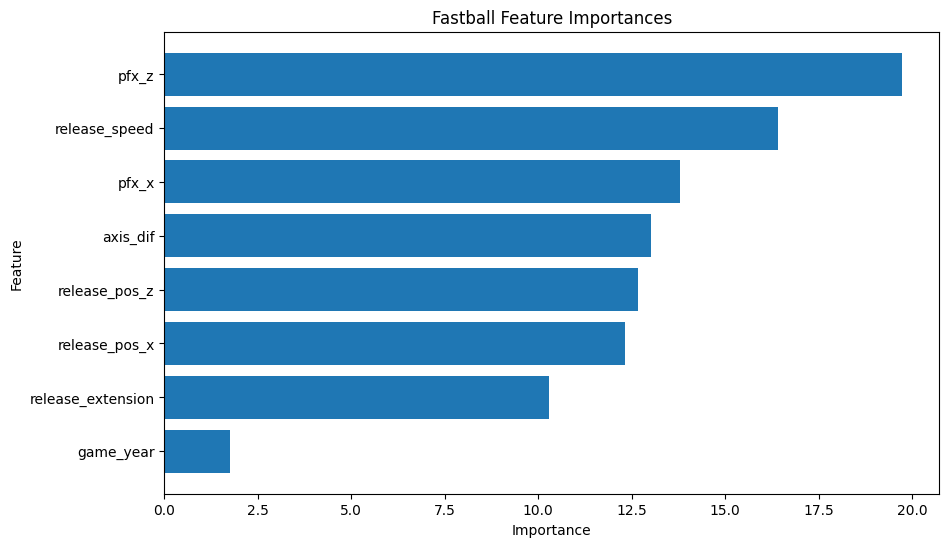

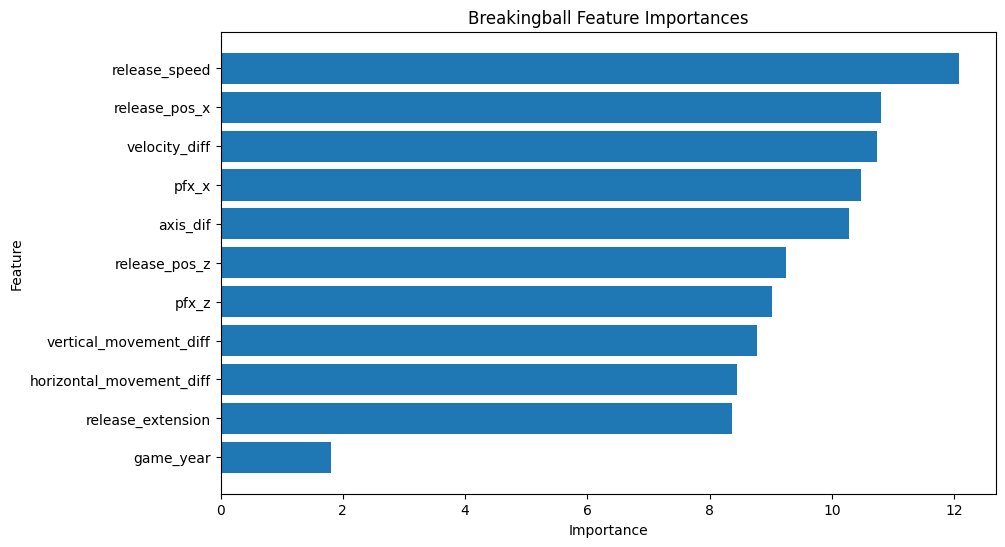

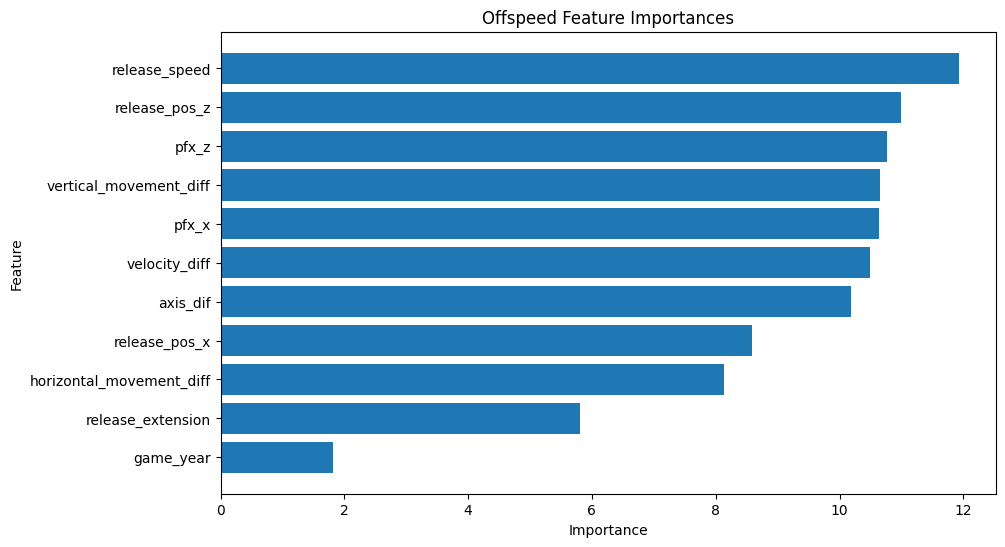

In [28]:
def plot_feature_importances(model, feature_names, title):
    feature_importances = model.get_feature_importance()
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    }).sort_values(by='importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()
    
plot_feature_importances(fastball_model, fball_features, 'Fastball Feature Importances')
plot_feature_importances(breakingball_model, features, 'Breakingball Feature Importances')
plot_feature_importances(offspeed_model, features, 'Offspeed Feature Importances')


In [206]:
fastball_model.save_model('fastball_model_6_22_3model_data20_23.cbm')
breakingball_model.save_model('breakingball_model_6_22_3model_data20_23.cbm')
offspeed_model.save_model('offspeed_model_6_22_3model_data20_23.cbm')

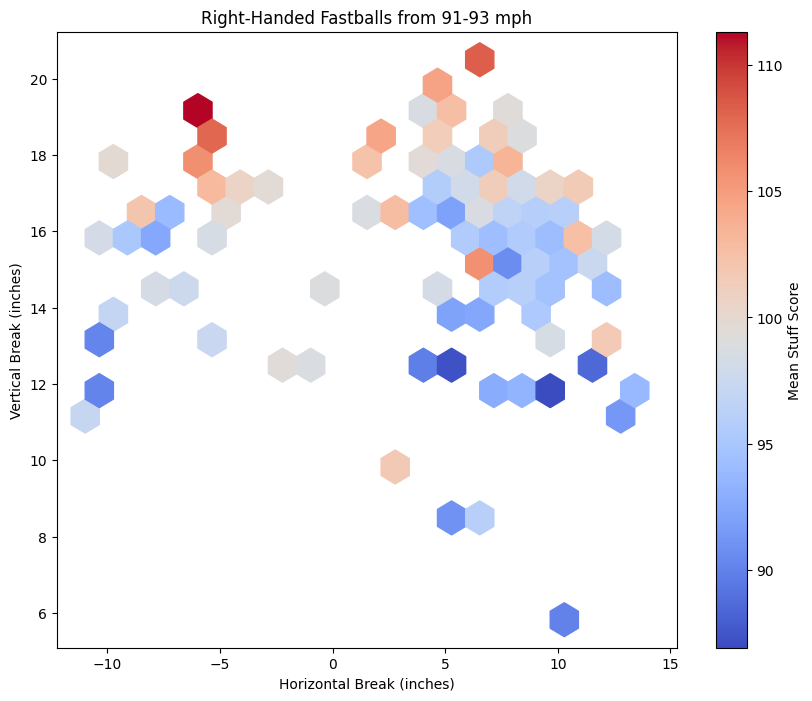

In [34]:
import matplotlib.pyplot as plt


# Filter data for fastballs within the 91-93 mph range
velocity_range = (94, 95)
filtered_data = fastball_graphic_data[(fastball_graphic_data['release_speed'] >= velocity_range[0]) & 
                                    (fastball_graphic_data['release_speed'] <= velocity_range[1])]

# Group by horizontal and vertical break and calculate the mean "stuff" score
grouped_data = filtered_data.groupby(['pfx_x', 'pfx_z'])['mean_scores'].mean().reset_index()

# Create hexbin plot
fig, ax = plt.subplots(figsize=(10, 8))

hb = ax.hexbin(grouped_data['pfx_x'], grouped_data['pfx_z'], C=grouped_data['mean_scores'], gridsize=20, cmap='coolwarm', reduce_C_function=np.mean)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Mean Stuff Score')

ax.set_xlabel('Horizontal Break (inches)')
ax.set_ylabel('Vertical Break (inches)')
ax.set_title('Right-Handed Fastballs from 91-93 mph')

plt.show()

In [113]:
import pandas as pd
import numpy as np

# First, let's filter for right-handed curveballs only
rhp_curveballs = curveball_23[curveball_23['p_throws'] == 1]  # Assuming 1 represents right-handed pitchers

# Isolate Tyson Miller's curveball data
tyson_miller_curveballs = rhp_curveballs[rhp_curveballs['player_name'] == 'Miller, Tyson']

# Calculate the mean values for Tyson Miller's curveball
tyson_miller_mean = tyson_miller_curveballs[features + ['score']].mean()

# Calculate the overall mean values for all right-handed curveballs
all_rhp_curveballs_mean = rhp_curveballs[features + ['score']].mean()

# Compare Tyson Miller's curveball to the average of right-handed curveballs
comparison = pd.DataFrame({
    'Tyson Miller': tyson_miller_mean,
    'RHP Curveballs Avg': all_rhp_curveballs_mean,
    'Difference': tyson_miller_mean - all_rhp_curveballs_mean
})

print("Comparison of Tyson Miller's curveball to the average right-handed curveball:")
print(comparison)

# Let's see the feature importances for the breaking ball model
feature_importances = pd.DataFrame({
    'feature': features,
    'importance': breakingball_model.get_feature_importance()
}).sort_values('importance', ascending=False)

print("\nBreaking ball model feature importances:")
print(feature_importances)

# Now, let's look at the distribution of Tyson Miller's curveball features
print("\nDistribution of Tyson Miller's curveball features:")
print(tyson_miller_curveballs[features].describe())

# Let's also check if there are any extreme outliers
print("\nPotential outliers in Tyson Miller's curveball data:")
for feature in features:
    q1 = tyson_miller_curveballs[feature].quantile(0.25)
    q3 = tyson_miller_curveballs[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    outliers = tyson_miller_curveballs[(tyson_miller_curveballs[feature] < lower_bound) | (tyson_miller_curveballs[feature] > upper_bound)]
    if not outliers.empty:
        print(f"Outliers for {feature}:")
        print(outliers[feature])
        print()

# Additional analysis: Percentile ranking of Tyson Miller's average curveball metrics
percentile_ranks = {}
for feature in features + ['score']:
    all_values = rhp_curveballs[feature]
    miller_value = tyson_miller_mean[feature]
    percentile = (all_values < miller_value).mean() * 100
    percentile_ranks[feature] = percentile

print("\nPercentile ranking of Tyson Miller's curveball metrics (compared to other RHP):")
for feature, percentile in percentile_ranks.items():
    print(f"{feature}: {percentile:.2f}th percentile")

Comparison of Tyson Miller's curveball to the average right-handed curveball:
                          Tyson Miller  RHP Curveballs Avg  Difference
release_speed                80.203226           80.318870   -0.115644
release_pos_x                -3.875484           -1.738006   -2.137478
release_pos_z                 4.906452            5.901270   -0.994819
release_extension             7.270968            6.369047    0.901920
pfx_x                       -12.549677           -9.118938   -3.430739
pfx_z                        -7.505806           -9.714815    2.209008
axis_dif                    -28.595171           13.147982  -41.743152
velocity_diff                10.753263           13.485716   -2.732453
horizontal_movement_diff     13.884334           16.976622   -3.092288
vertical_movement_diff       17.690234           23.365058   -5.674824
game_year                  2023.000000         2023.000000    0.000000
score                       -40.838748           99.559529 -140.398277